In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

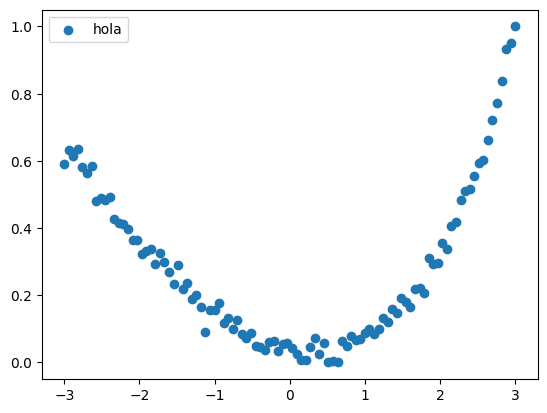

In [2]:
x = np.linspace(-3,3,100)
y_true = -2*x + x**2 + + np.exp(x) + norm.rvs(size=100)/2
y_true = (y_true-np.min(y_true))/(np.max(y_true)-np.min(y_true))
plt.scatter(x,y_true,label='hola')
plt.legend()

### Rubbish

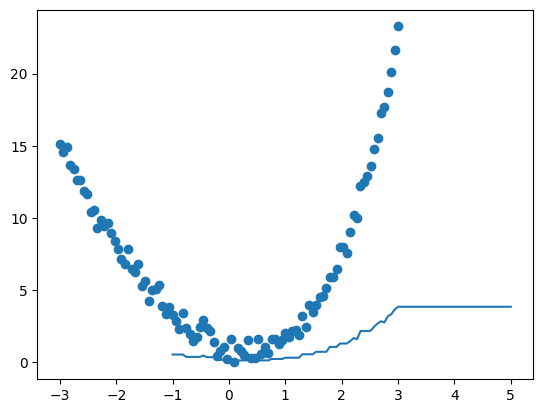

In [15]:
def gradient_se(y_true, y_pred):
    #Compute the gradient squared error.
    return (-2 * y_true)/2 + (2 * y_pred)*3

def hessian_se(y_true, y_pred):
    #Compute the hessian for squared error
    return 0*(y_true + y_pred) + 2

def custom_se(y_true, y_pred):
    #squared error objective. A simplified version of MSE used as
    #objective function.
    grad = gradient_se(y_true, y_pred)
    hess = hessian_se(y_true, y_pred)
    return grad, hess

model_custom = xgb.XGBRegressor(n_estimators=10, verbosity=2,subsample=.7,max_depth=3,objective=custom_se)
model_custom.fit(pd.DataFrame({'x':x}),y_true)
y_pred = model_custom.predict(pd.DataFrame({'x':x+2}))
a = y_pred
plt.scatter(x,y_true)
plt.plot(x+2,y_pred)

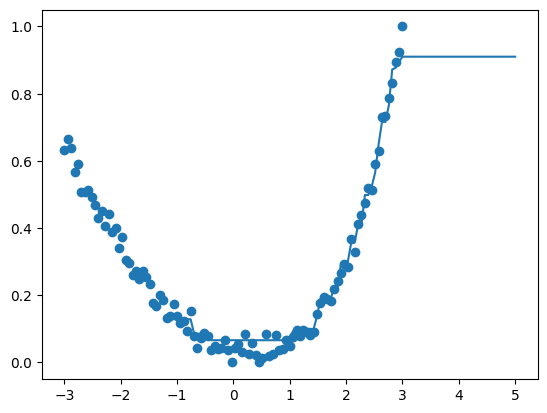

In [31]:
# https://medium.com/@pumaline/loss-functions-in-xgboost-c89885b57346

def gradient_se(y_true, y_pred):
    #Compute the gradient squared error.
    return (-2 * y_true) + (2 * y_pred)

def hessian_se(y_true, y_pred):
    #Compute the hessian for squared error
    return 0*(y_true + y_pred) + 2

def custom_se(y_true, y_pred):
    #squared error objective. A simplified version of MSE used as
    #objective function.
    grad = gradient_se(y_true, y_pred)
    hess = hessian_se(y_true, y_pred)
    return grad, hess

model_custom = xgb.XGBRegressor(n_estimators=10, verbosity=2,subsample=.7,max_depth=3,objective=custom_se)
model_custom.fit(pd.DataFrame({'x':x}),y_true)
y_pred = model_custom.predict(pd.DataFrame({'x':x+2}))
b = y_pred
plt.scatter(x,y_true)
plt.plot(x+2,y_pred)

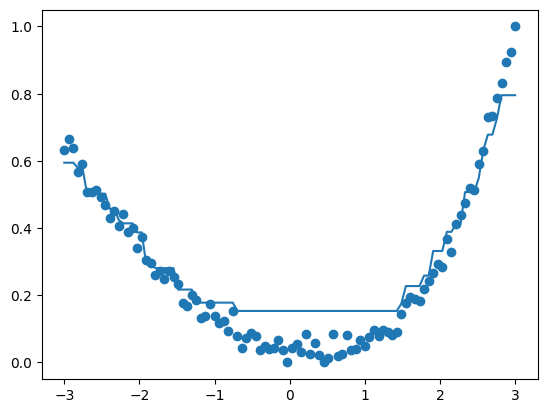

In [32]:
def sera_loss(y_true, y_pred, exp=2):
    # phis = y_true.copy()
    # phis -= 1
    # phis = phis**exp
    # mplus = np.max(phis)
    # mminus = np.min(phis)
    # phis -= mminus
    # phis /= (mplus-mminus)
    phis = np.ones(len(y_true))

    grad = 2*(y_pred - y_true)*phis
    hess = 2*phis
    
    return grad, hess

model_custom = xgb.XGBRegressor(n_estimators=5, verbosity=2,subsample=.7,max_depth=3,objective=sera_loss)
model_custom.fit(pd.DataFrame({'x':x}),y_true)
y_pred = model_custom.predict(pd.DataFrame({'x':x}))
a = y_pred
plt.scatter(x,y_true)
plt.plot(x,y_pred)

### Good stuff

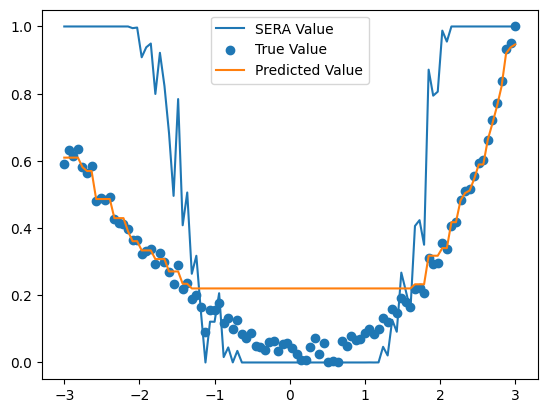

In [3]:
def sera_loss(y_true, y_pred,min_p=30,max_p=70):
    if not hasattr(sera_loss, "first_run"):
        sera_loss.first_run = True
    
    mini = np.min(y_true)-1e-3
    maxi = np.max(y_true)+1e-3
    semi1 = np.percentile(y_true, min_p)
    semi2 = np.percentile(y_true, max_p)
    pchip = CubicHermiteSpline([mini,semi1,semi2,maxi],[0,0,1,1],[0,0,0,0])
    pchip_v = np.vectorize(pchip)
    phis = pchip_v(y_true)
    if sera_loss.first_run:
        plt.plot(x,phis,label='SERA Value')
        sera_loss.first_run = False

    grad = 2*(y_pred - y_true)*phis
    hess = 2*phis
    
    return grad, hess
# plt.subplots(1,1)
model_custom = xgb.XGBRegressor(n_estimators=10, verbosity=2,subsample=1,max_depth=3,objective=sera_loss)
model_custom.fit(pd.DataFrame({'y':x}),y_true)
y_pred = model_custom.predict(pd.DataFrame({'y':x}))
a = y_pred
plt.scatter(x,y_true,label='True Value')
plt.plot(x,y_pred,label='Predicted Value')
plt.legend()

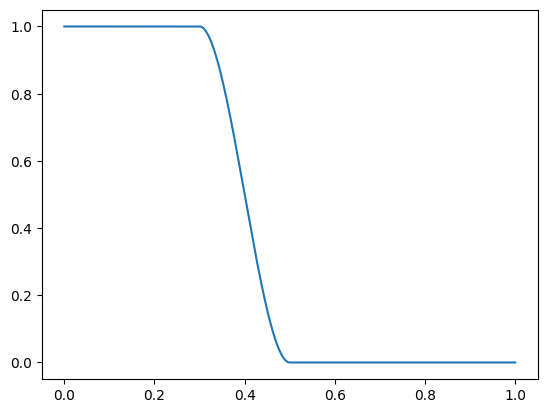

In [79]:
# def cubic_hermite_interpolation(points, derivatives):
#   """
#   Performs cubic Hermite interpolation for a series of points.

#   Args:
#       points: A list of tuples (x, y) representing data points.
#       derivatives: A list of floats representing the derivative (dy/dx) at each point.

#   Returns:
#       A function that takes an x value and returns the interpolated y value.
#   """

#   # Check input lengths
#   if len(points) != len(derivatives):
#     raise ValueError("Points and derivatives lists must have the same length")

#   # Convert points and derivatives to numpy arrays
#   x = np.array([point[0] for point in points])
#   y = np.array([point[1] for point in points])
#   dy_dx = np.array(derivatives)

#   def interpolate(x_val):
#     """
#     Inner function that performs the interpolation for a given x value.
#     """
#     # Find the segment where x_val belongs
#     i = np.searchsorted(x, x_val, side='left') - 1
#     if i < 0 or i >= len(x) - 1:
#       raise ValueError("x value out of interpolation range")

#     # Local variables for this segment
#     xi = x[i]
#     yi = y[i]
#     d1i = dy_dx[i]
#     xdi = x[i + 1] - xi
#     ydi = y[i + 1] - yi
#     d2i = dy_dx[i + 1]

#     # Cubic Hermite interpolation formula
#     t = (x_val - xi) / xdi
#     h1 = (1 + 2 * t * t - 3 * t**3) * yi + (t - 2 * t**2 + 3 * t**3) * ydi
#     h2 = (t**2 * (3 - 2 * t)) * d1i + (t**2 * (t - 1)) * d2i

#     return h1 + h2

#   return interpolate


def sera_loss(y_true, y_pred, dt=.001, min_p=.05):
    mini = np.min(y_true)-1e-6
    maxi = np.max(y_true)+1e-6
    semi1 = np.percentile(y_true, min_p)
    semi2 = np.percentile(y_true, .15)
    # pchip = pchip_interpolator([mini,semi1,semi2,maxi],[1,.99,.8,0],[0,0,-3,0])
    # x = np.linspace(0,1,int(1/dt))
    # pchip_v = np.vectorize(pchip)
    # phis = pchip_v(x)
    # plt.plot(x,phis)
    pchip = CubicHermiteSpline([mini,.3,.5,maxi],[1,1,0,0],[0,0,0,0])
    x = np.linspace(0,1,int(1/dt))
    pchip_v = np.vectorize(pchip)
    phis = pchip_v(x)
    plt.plot(x,phis)

# plt.scatter(x,y_true)
# plt.plot(x,y_pred)
sera_loss(y_true,y_pred)

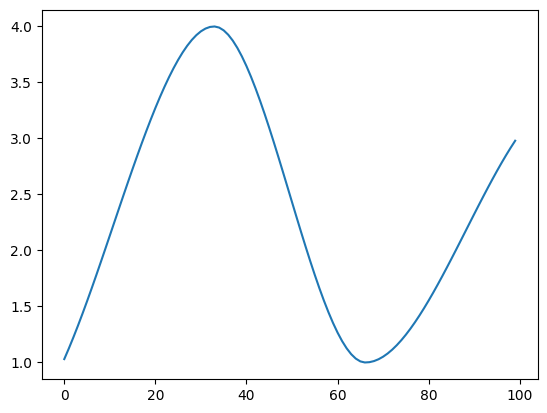

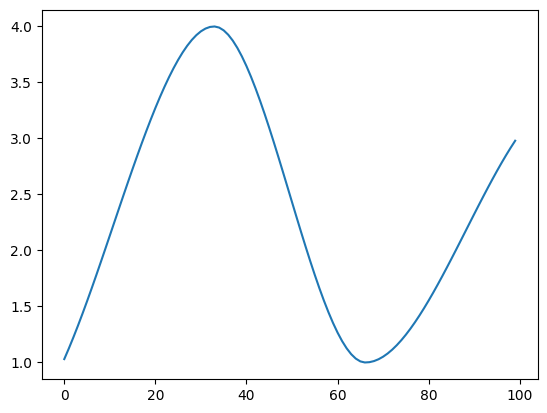

In [46]:
x = np.linspace(1.01,3.99,100)
pchip_v = np.vectorize(pchip)
y = pchip_v(x)
plt.plot(y)